```{index} single: AMPL; sets
```
```{index} single: AMPL; parameters
```
```{index} single: solver; highs
```
```{index} single: application; production planning
```
```{index} pandas dataframe
```

# BIM production revisited

In [ ]:
# install dependencies and select solver
%pip install -q amplpy

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Problem description

We consider BIM raw material planning, but now with more sophisticated pricing and acquisition protocols. There are now three suppliers, each of which can deliver the following materials:
 - A: **silicon**, **germanium** and **plastic**
 - B: **copper**
 - C: all of the above
 
For the suppliers, the following conditions apply. Copper should be acquired in multiples of 100 gram, since it is delivered in sheets of 100 gram. Unitary materials such as silicon, germanium and plastic may be acquired in any number, but the price is in batches of 100. Meaning that 30 units of silicon with 10 units of germanium and 50 units of plastic cost as much as 1 unit of silicon but half as much as 30 units of silicon with 30 units of germanium and 50 units of plastic. Furthermore, supplier C sells all materials and offers a discount if purchased together: 100 gram of copper and a batch of unitary material cost just 7. This set price is only applied to pairs, meaning that 100 gram of copper and 2 batches cost 13.

The summary of the prices in &euro; is given in the following table:

|Supplier|Copper per sheet of 100 gram|Batch of units|Together|
|:-------|---------------------:|-----------------:|-------:|
| A      |                    - |                5 |      - |
| B      |                    3 |                - |      - |
| C      |                    4 |                6 |      7 |

Next, for stocked products inventory costs are incurred, whose summary is given in the following table:

|Copper per 10 gram| Silicon per unit| Germanium per unit|Plastic per unit|
|---:|-------:|---:|-----:|
| 0.1|   0.02 |0.02| 0.02 |

The holding price of copper is per 10 gram and the copper stocked is rounded up to multiples of 10 grams, meaning that 12 grams pay for 20. 

The capacity limitations of the warehouse allow for a maximum of $10$ kilogram of copper in stock at any moment, but there are no practical limitations to the number of units of unitary products in stock.

Recall that BIM has the following stock at the beginning of the year:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 480|   1000 |1500| 1750 |

The company would like to have at least the following stock at the end of the year:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 200|    500 | 500| 1000 |

The goal is to build an optimization model using the data above and solve it to minimize the acquisition and holding costs of the products while meeting the required quantities for production. The production is made-to-order, meaning that no inventory of chips is kept.


In [91]:
from io import StringIO
import pandas as pd

demand_data = """
chip, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
logic, 88, 125, 260, 217, 238, 286, 248, 238, 265, 293, 259, 244
memory, 47, 62, 81, 65, 95, 118, 86, 89, 82, 82, 84, 66
"""

demand_chips = pd.read_csv(StringIO(demand_data), index_col="chip")
display(demand_chips)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
logic,88,125,260,217,238,286,248,238,265,293,259,244
memory,47,62,81,65,95,118,86,89,82,82,84,66


In [92]:
use = dict()
use["logic"] = {"silicon": 1, "plastic": 1, "copper": 4}
use["memory"] = {"germanium": 1, "plastic": 1, "copper": 2}
use = pd.DataFrame.from_dict(use).fillna(0).astype(int)
display(use)

,logic,memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


In [93]:
demand = use.dot(demand_chips)
display(demand)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


In [94]:
%%writefile BIMproduction_v1.mod

set periods ordered;
set products;
set supplying_batches;
set supplying_copper;
set unitary_products;

param delta{products, periods}; # demand
param pi{supplying_batches};    # aquisition price
param kappa{supplying_copper};  # price of copper sheet
param beta;
param gamma{products};          # unitary holding costs
param Alpha{products};          # initial stock
param Omega{products};          # desired stock
param copper_bucket_size;
param stock_limit;
param batch_size;
param copper_sheet_mass;

var y{periods, supplying_copper} integer >= 0;
var x{unitary_products, periods, supplying_batches} >= 0;
var ss{products, periods} >= 0;
var uu{products, periods} >= 0;
var bb{periods, supplying_batches} integer >= 0;
var pp{periods} integer >= 0;
var rr{periods} integer >= 0;

s.t. units_in_batches {t in periods, s in supplying_batches}:
    sum{p in unitary_products} x[p,t,s] <= batch_size * bb[t,s];
s.t. copper_in_buckets {t in periods}:
    ss['copper', t] <= copper_bucket_size * rr[t];
s.t. inventory_capacity {t in periods}:
    ss['copper', t] <= stock_limit;
s.t. pairs_in_batches {t in periods}:
    pp[t] <= bb[t,'C'];
s.t. pairs_in_sheets {t in periods}:
    pp[t] <= y[t,'C'];
s.t. bought {t in periods, p in products}:
    (if p == 'copper' then
        copper_sheet_mass * sum{s in supplying_copper} y[t,s]
    else
        sum{s in supplying_batches} x[p,t,s])
    == uu[p,t];

var acquisition_cost =
    sum{t in periods}(
        sum{s in supplying_batches} pi[s] * bb[t,s] +
        sum{s in supplying_copper} kappa[s] * y[t,s] -
        beta * pp[t]
    );
var inventory_cost =
    sum{t in periods}(
        gamma['copper'] * rr[t] + 
        sum{p in unitary_products} gamma[p] * ss[p,t]
    );

minimize total_cost: acquisition_cost + inventory_cost;
   
s.t. balance {p in products, t in periods}:
    (if t == first(periods) then
        Alpha[p]
    else
        ss[p,prev(t)]) +
    uu[p,t] == delta[p,t] + ss[p,t];
s.t. finish {p in products}:
    ss[p, last(periods)] >= Omega[p];

Overwriting BIMproduction_v1.mod


In [95]:
def BIMproduction_v1(
    demand,
    existing,
    desired,
    stock_limit,
    supplying_copper,
    supplying_batches,
    price_copper_sheet,
    price_batch,
    discounted_price,
    batch_size,
    copper_sheet_mass,
    copper_bucket_size,
    unitary_products,
    unitary_holding_costs,
):
    m = AMPL()
    m.read("BIMproduction_v1.mod")

    m.set["periods"] = demand.columns
    m.set["products"] = demand.index
    m.param["delta"] = demand

    m.set["supplying_batches"] = supplying_batches
    m.param["pi"] = price_batch

    m.set["supplying_copper"] = supplying_copper
    m.param["kappa"] = price_copper_sheet

    m.param["beta"] = price_batch["C"] + price_copper_sheet["C"] - discounted_price

    m.set["unitary_products"] = unitary_products
    m.param["gamma"] = unitary_holding_costs

    m.param["Alpha"] = existing
    m.param["Omega"] = desired

    m.param["batch_size"] = batch_size
    m.param["copper_bucket_size"] = copper_bucket_size
    m.param["stock_limit"] = stock_limit
    m.param["copper_sheet_mass"] = copper_sheet_mass

    return m

In [96]:
m1 = BIMproduction_v1(
    demand=demand,
    existing={"silicon": 1000, "germanium": 1500, "plastic": 1750, "copper": 4800},
    desired={"silicon": 500, "germanium": 500, "plastic": 1000, "copper": 2000},
    stock_limit=10000,
    supplying_copper=["B", "C"],
    supplying_batches=["A", "C"],
    price_copper_sheet={"B": 300, "C": 400},
    price_batch={"A": 500, "C": 600},
    discounted_price=700,
    batch_size=100,
    copper_sheet_mass=100,
    copper_bucket_size=10,
    unitary_products=["silicon", "germanium", "plastic"],
    unitary_holding_costs={"copper": 10, "silicon": 2, "germanium": 2, "plastic": 2},
)

m1.option["solver"] = SOLVER
m1.option["highs_options"] = "outlev=1"
m1.solve()

HiGHS 1.5.1: tech:outlev=1
Running HiGHS 1.5.1 [date: 2023-06-22, git hash: 93f1876]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
152 rows, 236 cols, 444 nonzeros
113 rows, 197 cols, 366 nonzeros
96 rows, 156 cols, 285 nonzeros

Solving MIP model with:
   96 rows
   156 cols (0 binary, 72 integer, 23 implied int., 61 continuous)
   285 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -inf            inf                  inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   109104          114244             4.50%        0      0      0        67     0.1s
 L       0       0         0   0.00%   109957.085557   110216             0.23%      926     61      0       331     0.9s

2.8% inactive integ

In [97]:
stock = m1.var["ss"].to_pandas()
stock.columns = stock.columns.get_level_values(1)
stock = stock.reindex(index=demand.index, columns=demand.columns)
display(stock)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912.0,787.0,527.0,310.0,72.0,15.0,0.0,0.0,0.0,56.0,54.0,500.0
plastic,1615.0,1428.0,1087.0,805.0,472.0,68.0,1.0,36.0,24.0,0.0,0.0,1000.0
copper,4354.0,3730.0,2528.0,1530.0,388.0,8.0,44.0,14.0,90.0,54.0,50.0,2042.0
germanium,1453.0,1391.0,1310.0,1245.0,1150.0,1032.0,946.0,857.0,775.0,693.0,609.0,543.0


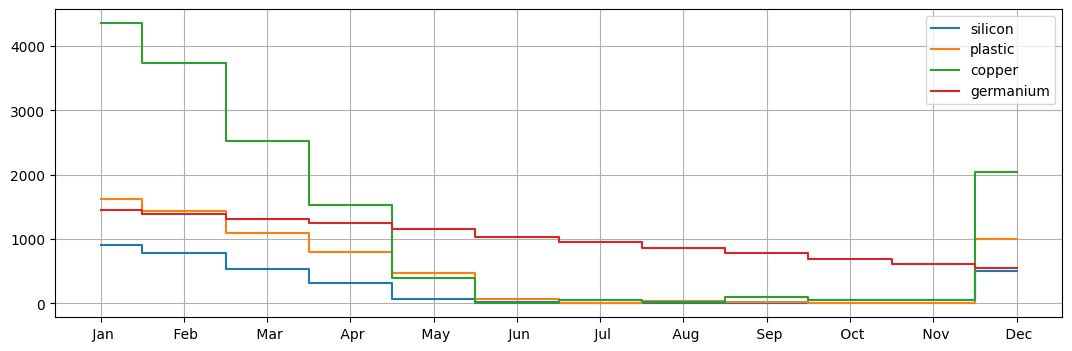

In [98]:
import matplotlib.pyplot as plt, numpy as np

stock.T.plot(drawstyle="steps-mid", grid=True, figsize=(13, 4))
plt.xticks(np.arange(len(stock.columns)), stock.columns)
plt.show()

In [99]:
m1.var["pp"].to_pandas().T

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
pp.val,0.0,0.0,0.0,0.0,0.0,3.0,5.0,6.0,6.0,7.0,6.0,20.0


In [100]:
df = m1.var["uu"].to_pandas().unstack()
df.columns = df.columns.get_level_values(1)
df = df.reindex(index=demand.index, columns=demand.columns)
display(df)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,0.0,0.0,0.0,0.0,0.0,229.0,233.0,238.0,265.0,349.0,257.0,690.0
plastic,0.0,0.0,0.0,0.0,0.0,0.0,267.0,362.0,335.0,351.0,343.0,1310.0
copper,0.0,0.0,0.0,0.0,0.0,1000.0,1200.0,1100.0,1300.0,1300.0,1200.0,3100.0
germanium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
b = m1.var["bb"].to_pandas().unstack().T
b.index = b.index.get_level_values(1)
b = b.reindex(columns=demand.columns)
b.index.names = [None]
display(b)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,3.0,5.0,6.0,6.0,7.0,6.0,20.0


In [102]:
y = m1.var["y"].to_pandas().unstack().T
y.index = y.index.get_level_values(1)
y = y.reindex(columns=demand.columns)
y.index.names = [None]
display(y)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
B,0.0,0.0,0.0,0.0,0.0,7.0,7.0,5.0,7.0,6.0,6.0,11.0
C,0.0,0.0,0.0,0.0,0.0,3.0,5.0,6.0,6.0,7.0,6.0,20.0


In [103]:
x = m1.var["x"].to_pandas().unstack(1)
x.columns = x.columns.get_level_values(1)
x = x.reindex(columns=demand.columns)
x.index.names = ["materials", "supplier"]
display(x)

Jan   Feb   Mar   Apr   May    Jun    Jul    Aug    Sep  \
materials supplier                                                             
germanium A          0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   
          C          0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   
plastic   A          0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   
          C          0.0   0.0   0.0   0.0   0.0    0.0  267.0  362.0  335.0   
silicon   A          0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   
          C          0.0   0.0   0.0   0.0   0.0  229.0  233.0  238.0  265.0   

                      Oct    Nov     Dec  
materials supplier                        
germanium A           0.0    0.0     0.0  
          C           0.0    0.0     0.0  
plastic   A           0.0    0.0     0.0  
          C         351.0  343.0  1310.0  
silicon   A           0.0    0.0     0.0  
          C         349.0  257.0   690.0